## Image Captioning - Pretrained Resnet50 with Attention

In [1]:
import os
from pathlib import Path
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from PIL import Image
from collections import Counter
import sys
import random
from nltk.translate.bleu_score import sentence_bleu

#PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split

#Vision
import torchvision.transforms as T
import torchvision.models as models

#Torchtext
#import torchtext; torchtext.disable_torchtext_deprecation_warning() #supress warning
from torchtext.vocab import vocab
#from torchtext.data.utils import get_tokenizer


For reproducibility:

In [2]:
def set_seed(seed):
    random.seed(seed)  #Python random module
    np.random.seed(seed)  #NumPy random module
    torch.manual_seed(seed)  #PyTorch CPU
    torch.cuda.manual_seed(seed)  #PyTorch GPU
    torch.cuda.manual_seed_all(seed)  #Multi-GPU setups
    torch.backends.cudnn.deterministic = True  #Deterministic behavior
    torch.backends.cudnn.benchmark = False  #Reproducibility

#set_seed(43)
set_seed(45)

Mapping google drive and extracting zip file

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# with zipfile.ZipFile('/content/drive/MyDrive/archive.zip') as z_temp:
#     z_temp.extractall()

In [4]:
#Run if needed
# with zipfile.ZipFile('data/archive.zip') as z_temp:
#     z_temp.extractall(path='data/')

Check path to the image files and caption file:

In [5]:
current_dir = Path.cwd()

if current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    project_root = current_dir

if project_root not in sys.path:
    sys.path.append(str(project_root))

captions_path = project_root / 'data' / 'flickr30k_images' / 'results.csv'
image_dir = project_root  / 'data' / 'flickr30k_images' / 'flickr30k_images'
image_paths = list(image_dir.glob('*.jpg'))

if captions_path.exists():
    print("Caption path exists")
else:
    print("Caption path does not exist")

if image_dir.exists() and image_dir.is_dir():
    print("Image directory exists")
    
    if image_paths:
        print(f"Found {len(image_paths)} images in the directory.")
    else:
        print("No images found in the directory.")
else:
    print("Image directory does not exist")


Caption path exists
Image directory exists
Found 31783 images in the directory.


Check caption.txt file and get the random raws (7 samples) from it

In [6]:
image_captions = pd.read_csv(captions_path, sep='|')
image_captions.columns = image_captions.columns.str.strip()
image_captions.sample(7)

image_name comment_number  \
130622  5075763701.jpg              2   
13286   1873666741.jpg              1   
40444    271025171.jpg              4   
39496   2687977103.jpg              1   
93773   4194543575.jpg              3   
113735  4729243462.jpg              0   
36685   2612781974.jpg              0   

                                                  comment  
130622   A bike rider on his side on a dirt road with ...  
13286    A man in a yellow vest is smoking and working...  
40444                       A lady is doing some acting .  
39496    A man in a white t-shirt leans on a car while...  
93773    Various people out and about in a public plac...  
113735   A man with a gray beard and glasses sits rela...  
36685    A man is in a midair jump over another man wh...

In [7]:
image_captions.shape

(158915, 3)

As we can see our caption file is the size of (158915, 3):

**image_name:** This is for filenames of the images, such as 3756150099.jpg, 4014757090.jpg, etc. Each file related to a unique image in the dataset.

**comment_number:** This column is an identifier for the caption related with each image. Since each image in flickr30k might have multiple captions, comment_number distinguishes between them (e.g., 0, 1, 2, etc.).

**comment:** This column is for the actual caption text describing the content of the image.

In [8]:
#Handeling device selection
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Using en_core_web_lg to built vocabulary for our captions. WE are also adding special tokens UNK_TOKEN = 'unk', PAD_TOKEN = 'pad', SOS_TOKEN = 'sos', EOS_TOKEN = 'eos' to our vocabulary:

In [9]:
from src.vocab_builder import VocabularyBuilder

#Replace non-string values with empty string
image_captions['comment'] = image_captions['comment'].apply(lambda x: x if isinstance(x, str) else '')
text_lines = image_captions['comment'].tolist()

if Path.cwd().name == 'notebooks':
    os.chdir("..")

#Uncomment or comment if you want to load or build/save
vocab_builder = VocabularyBuilder(min_freq=2, save_path='./saved_model/vocab.pth', special_token=True)
#vocab = vocab_builder.build_vocab(text_lines)
vocab = vocab_builder.load_vocab(device)


In [10]:
words = vocab.get_itos()
print("Words in our vocab:", words)

vocab_length = len(vocab)
print(f"Total number of words in vocab: {vocab_length}")

Words in our vocab: ['<unk>', '<pad>', '<sos>', '<eos>', 'two', 'young', 'guy', 'with', 'shaggy', 'hair', 'look', 'at', 'their', 'hand', 'while', 'hang', 'out', 'in', 'the', 'yard', 'white', 'male', 'be', 'outside', 'near', 'many', 'bush', 'man', 'green', 'shirt', 'stand', 'a', 'blue', 'garden', 'friend', 'enjoy', 'time', 'spend', 'together', 'several', 'hard', 'hat', 'operate', 'giant', 'pulley', 'system', 'worker', 'down', 'from', 'up', 'above', 'on', 'piece', 'of', 'equipment', 'work', 'machine', 'wear', 'four', 'top', 'tall', 'structure', 'three', 'large', 'rig', 'child', 'pink', 'dress', 'climb', 'set', 'stair', 'an', 'entry', 'way', 'little', 'girl', 'go', 'into', 'wooden', 'cabin', 'to', 'her', 'playhouse', 'building', 'someone', 'and', 'lean', 'against', 'window', 'ladder', 'clean', 'jean', 'cleaning', 'one', 'gray', 'black', 'stove', 'cook', 'joke', 'around', 'camera', 'kitchen', 'food', 'prepare', 'meal', 'people', 'photo', 'play', 'guitar', 'other', 'poke', 'he', 'hold', 'ob

Creating our dataset instance:

In [11]:
from src.image_caption_dataset import ImageCaptionDataset

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

transforms = T.Compose([
    T.Resize((224, 224)), 
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])


flickr_dataset =  ImageCaptionDataset(
    image_paths = image_paths,
    captions = captions_path,
    vocabulary_builder=vocab_builder,
    transform = transforms
)

Normalized Image:


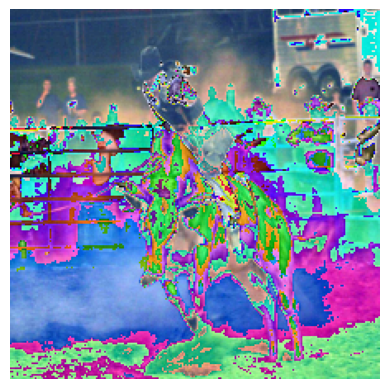

Denormalized Image:


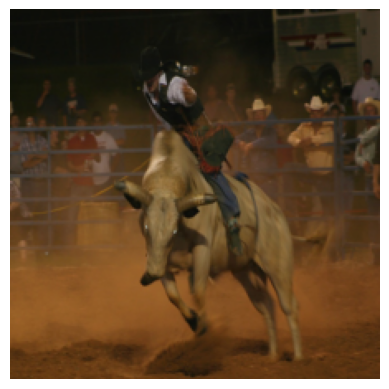

tensor([   2,   31,   27,    0, 6544,    0,   48,   18, 3370,  111,    0, 1993,
         621,   31, 2916,    3])
Caption :
<sos> a man <unk> being <unk> from the bull he <unk> riding during a rodeo <eos>


In [12]:
from src.utils import display_image
img, ids, cap_text = flickr_dataset[10366]
print("Normalized Image:")
display_image(img, denormalize=False)
print("Denormalized Image:")
display_image(img, denormalize=True, mean=mean, std=std)
print(ids)
print('Caption :')
print(vocab_builder.token_ids_to_caption(ids))

Defining dataloader for our dataset and also split dataset into train and test sets (80% train, 20% test)

In [13]:
train_size = int(0.8 * len(flickr_dataset))
test_size = len(flickr_dataset) - train_size
train_dataset, test_dataset = random_split(flickr_dataset, [train_size, test_size])

In [14]:
from src.batch_caption_collator import BatchCaptionCollator

pad_idx = vocab_builder.vocabulary['<pad>']
batch_size = 256
num_workers = 4
prefetch_factor = 4

collator = BatchCaptionCollator(pad_idx=pad_idx, batch_first=True)


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collator,
    num_workers=num_workers,
    prefetch_factor=prefetch_factor
)

test_loader  = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collator,
    num_workers=num_workers,
    prefetch_factor=prefetch_factor
)


Now it is time to define our model and hyperparameter:

In [15]:
vocab_size = len(vocab_builder.vocabulary)

emb_size = 300
attn_size = 256

drop_prob = 0.3

enc_hidden_size = 2048
#dec_hidden_size = 512
dec_hidden_size = 1024

learning_rate = 6e-4

In [16]:
from src.models.encoderdecoder import EncoderDecoder

model = EncoderDecoder(
    emb_size = emb_size,
    vocab_size = vocab_size,
    attn_size = attn_size,
    enc_hidden_size = enc_hidden_size,
    dec_hidden_size = dec_hidden_size,
    drop_prob = drop_prob,
    device = device
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

Epoch: 1, Batch: 200, Training Loss: 3.59921


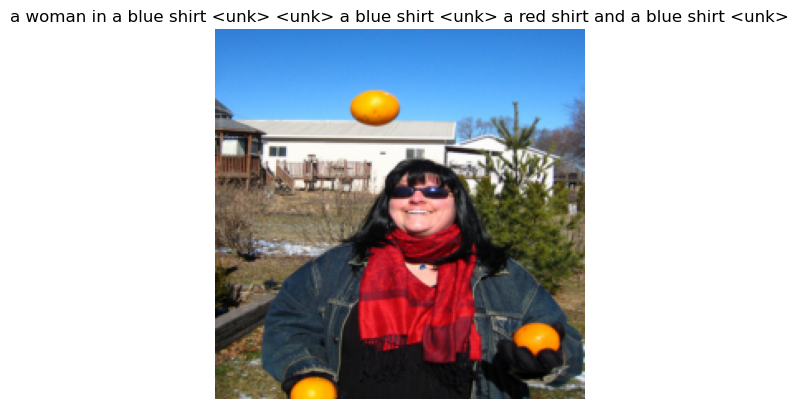

Epoch: 1, Batch: 400, Training Loss: 3.28283


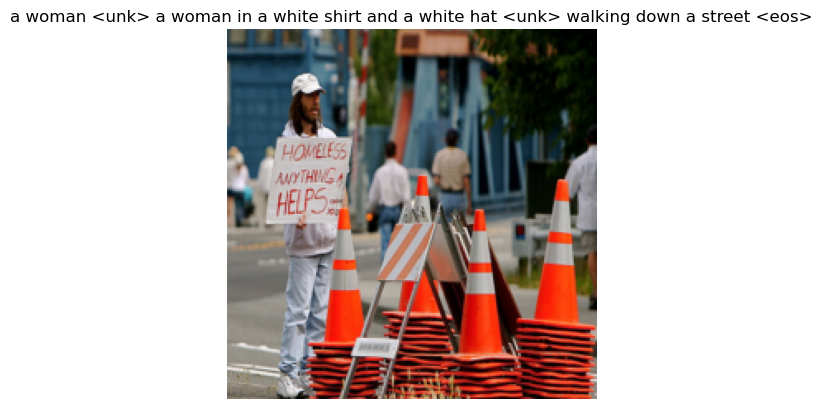

Epoch 1/15 - Training Loss: 3.7456, Validation Loss: 3.1512, BLEU Score: 0.0286, CIDEr Score: 0.0000, METEOR Score: 0.0000
Model saved at saved_model\model_epoch_1.pth
Epoch: 2, Batch: 200, Training Loss: 3.01194


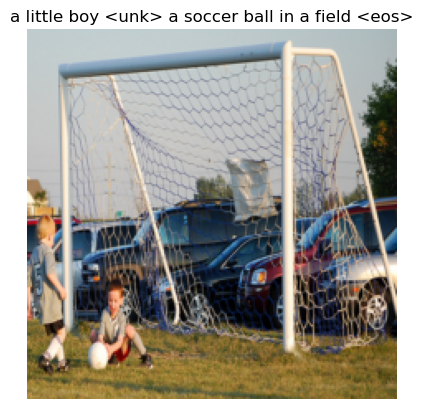

Epoch: 2, Batch: 400, Training Loss: 3.00797


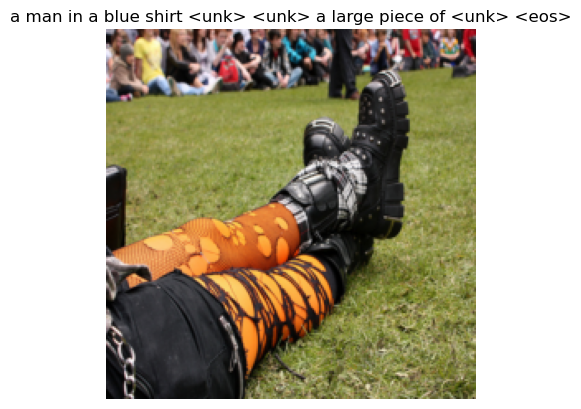

Epoch 2/15 - Training Loss: 3.0111, Validation Loss: 2.9004, BLEU Score: 0.0326, CIDEr Score: 0.0000, METEOR Score: 0.0000
Model saved at saved_model\model_epoch_2.pth
Epoch: 3, Batch: 200, Training Loss: 2.75551


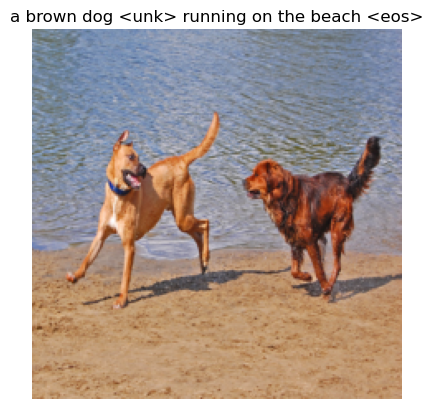

Epoch: 3, Batch: 400, Training Loss: 2.82724


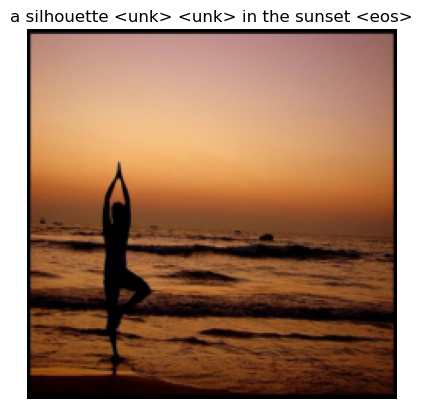

Epoch 3/15 - Training Loss: 2.7749, Validation Loss: 2.7807, BLEU Score: 0.0407, CIDEr Score: 0.0000, METEOR Score: 0.0000
Model saved at saved_model\model_epoch_3.pth
Epoch: 4, Batch: 200, Training Loss: 2.58008


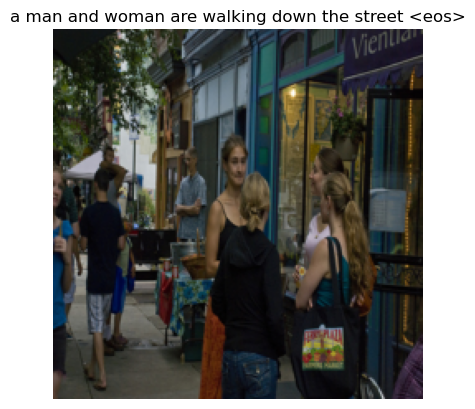

Epoch: 4, Batch: 400, Training Loss: 2.51429


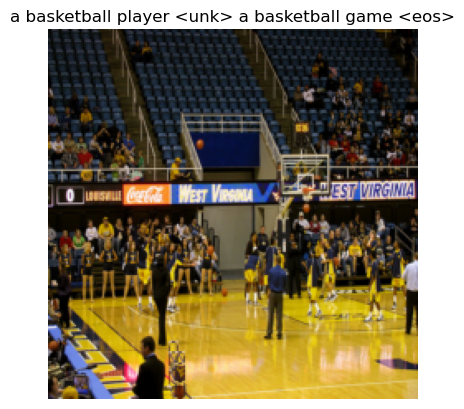

Epoch 4/15 - Training Loss: 2.6059, Validation Loss: 2.7104, BLEU Score: 0.0382, CIDEr Score: 0.0000, METEOR Score: 0.0000
Model saved at saved_model\model_epoch_4.pth
Epoch: 5, Batch: 200, Training Loss: 2.37118


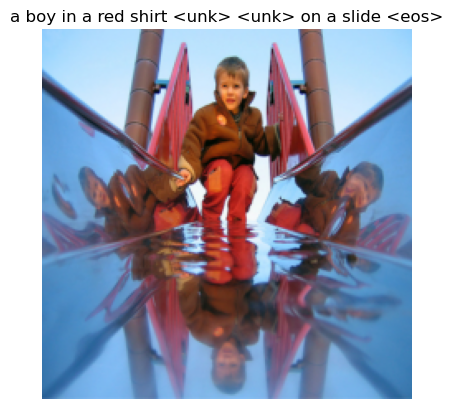

Epoch: 5, Batch: 400, Training Loss: 2.51951


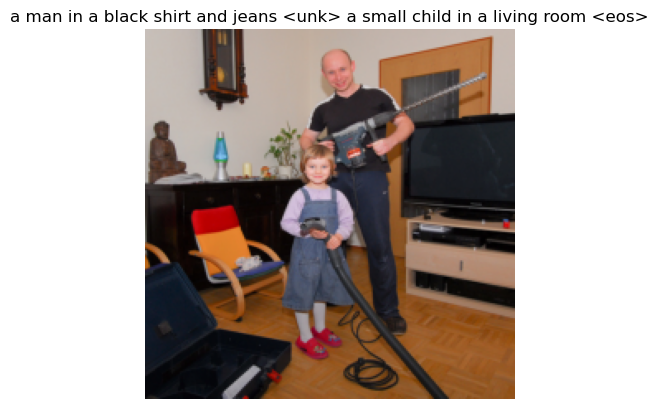

Epoch 5/15 - Training Loss: 2.4641, Validation Loss: 2.6631, BLEU Score: 0.0432, CIDEr Score: 0.0000, METEOR Score: 0.0000
Model saved at saved_model\model_epoch_5.pth
Epoch: 6, Batch: 200, Training Loss: 2.32409


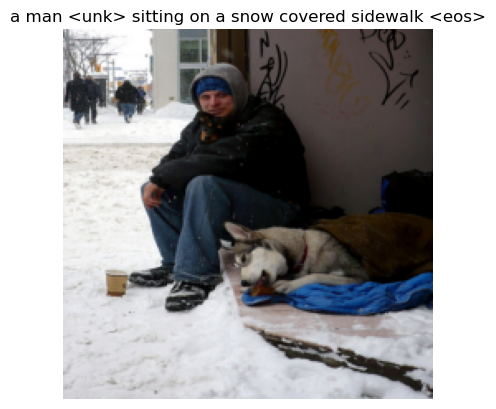

Epoch: 6, Batch: 400, Training Loss: 2.34940


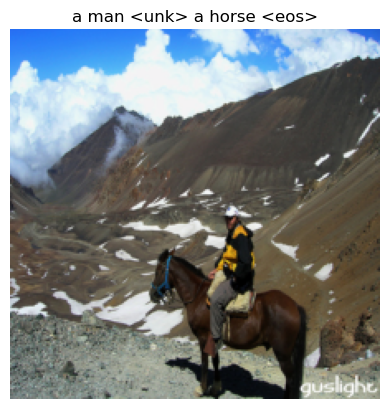

Epoch 6/15 - Training Loss: 2.3374, Validation Loss: 2.6346, BLEU Score: 0.0426, CIDEr Score: 0.0000, METEOR Score: 0.0000
Model saved at saved_model\model_epoch_6.pth
Epoch: 7, Batch: 200, Training Loss: 2.19501


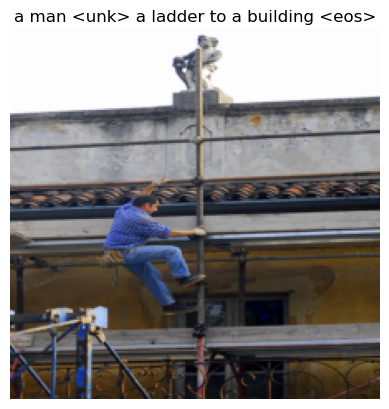

Epoch: 7, Batch: 400, Training Loss: 2.19225


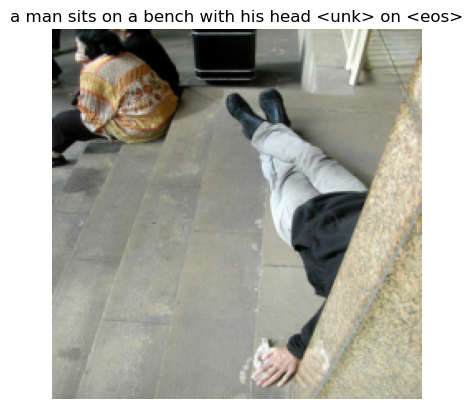

Epoch 7/15 - Training Loss: 2.2229, Validation Loss: 2.6205, BLEU Score: 0.0456, CIDEr Score: 0.0000, METEOR Score: 0.0000
Model saved at saved_model\model_epoch_7.pth
Epoch: 8, Batch: 200, Training Loss: 2.16577


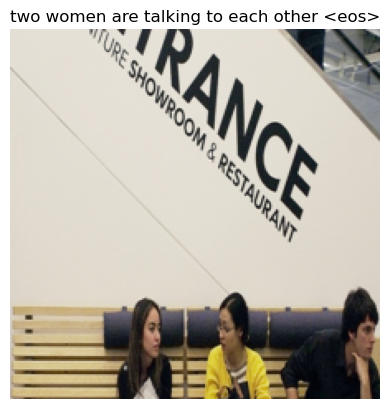

Epoch: 8, Batch: 400, Training Loss: 2.09566


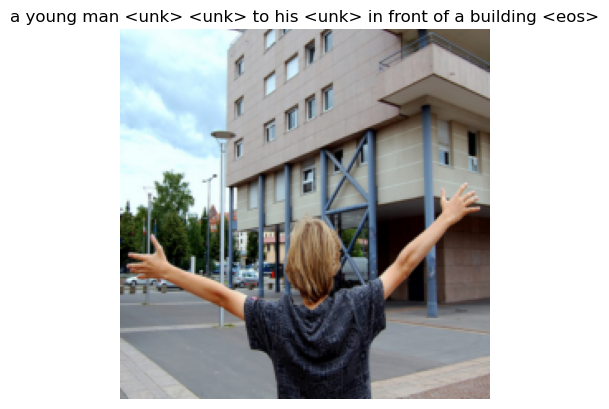

Epoch 8/15 - Training Loss: 2.1156, Validation Loss: 2.6149, BLEU Score: 0.0474, CIDEr Score: 0.0000, METEOR Score: 0.0000
Model saved at saved_model\model_epoch_8.pth
Epoch: 9, Batch: 200, Training Loss: 2.05977


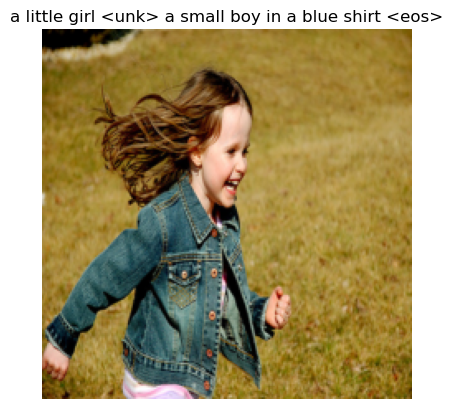

Epoch: 9, Batch: 400, Training Loss: 2.08214


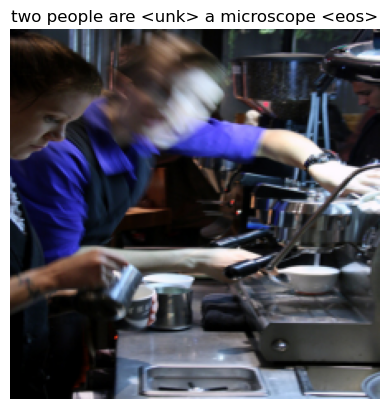

Epoch 9/15 - Training Loss: 2.0191, Validation Loss: 2.6149, BLEU Score: 0.0473, CIDEr Score: 0.0000, METEOR Score: 0.0000
Model saved at saved_model\model_epoch_9.pth
Epoch: 10, Batch: 200, Training Loss: 1.93231


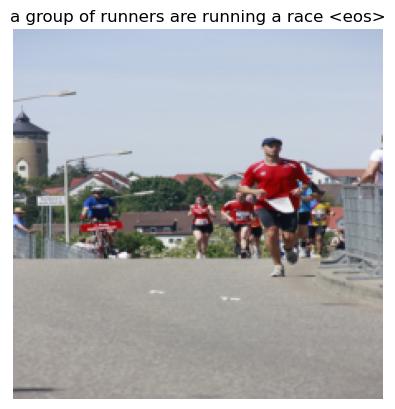

Epoch: 10, Batch: 400, Training Loss: 1.92411


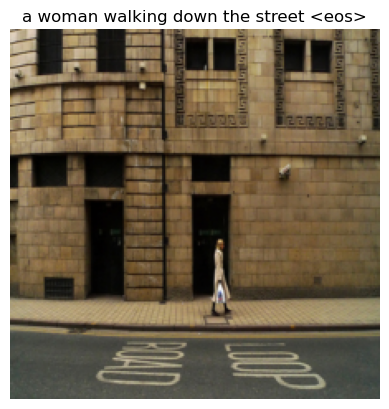

Epoch 10/15 - Training Loss: 1.9264, Validation Loss: 2.6260, BLEU Score: 0.0488, CIDEr Score: 0.0000, METEOR Score: 0.0000
Model saved at saved_model\model_epoch_10.pth
Epoch: 11, Batch: 200, Training Loss: 1.87634


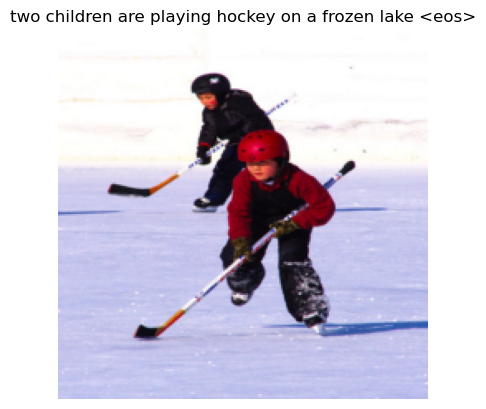

Epoch: 11, Batch: 400, Training Loss: 1.82760


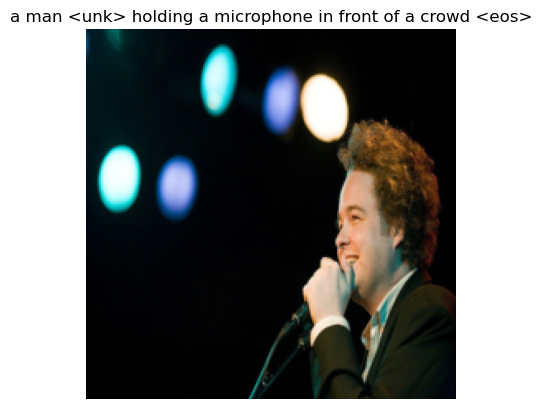

Epoch 11/15 - Training Loss: 1.8426, Validation Loss: 2.6406, BLEU Score: 0.0488, CIDEr Score: 0.0000, METEOR Score: 0.0000
Model saved at saved_model\model_epoch_11.pth
Epoch: 12, Batch: 200, Training Loss: 1.83235


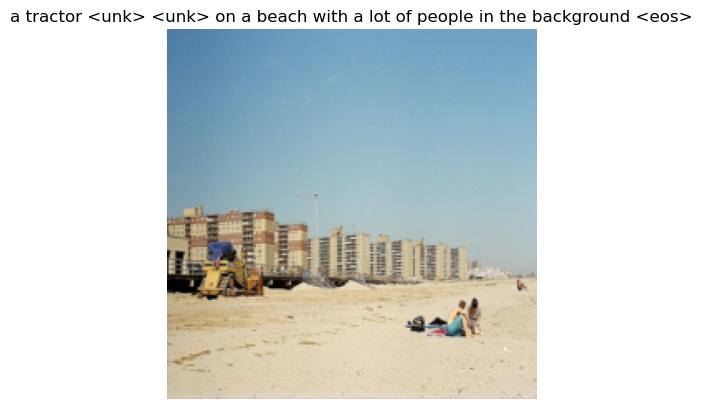

Epoch: 12, Batch: 400, Training Loss: 1.78272


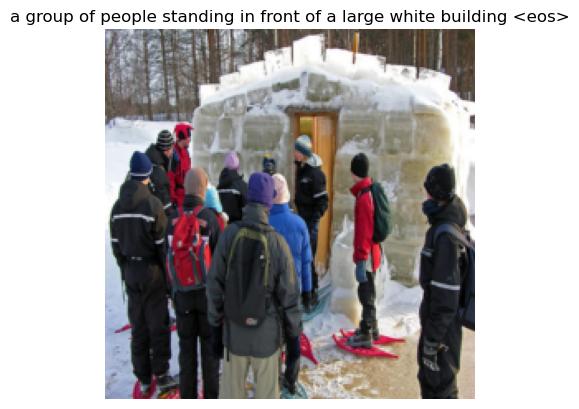

Epoch 12/15 - Training Loss: 1.7627, Validation Loss: 2.6643, BLEU Score: 0.0498, CIDEr Score: 0.0000, METEOR Score: 0.0000
Model saved at saved_model\model_epoch_12.pth
Epoch: 13, Batch: 200, Training Loss: 1.66383


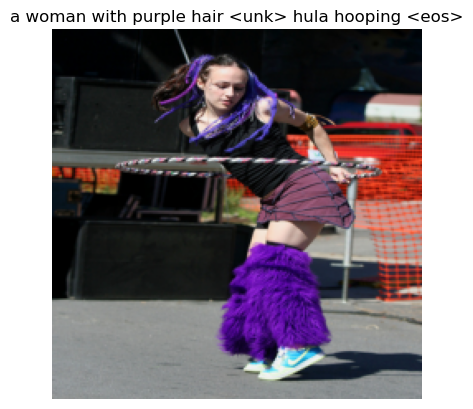

Epoch: 13, Batch: 400, Training Loss: 1.76682


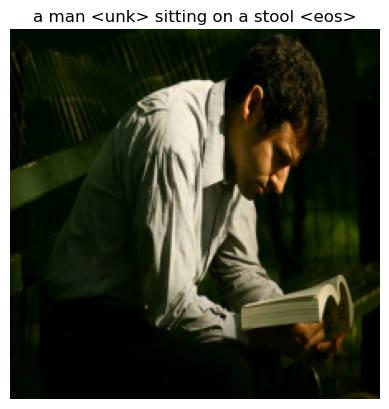

Epoch 13/15 - Training Loss: 1.6879, Validation Loss: 2.6892, BLEU Score: 0.0522, CIDEr Score: 0.0000, METEOR Score: 0.0000
Model saved at saved_model\model_epoch_13.pth
Epoch: 14, Batch: 200, Training Loss: 1.62637


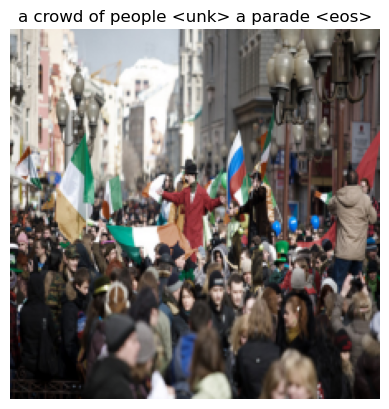

Epoch: 14, Batch: 400, Training Loss: 1.69270


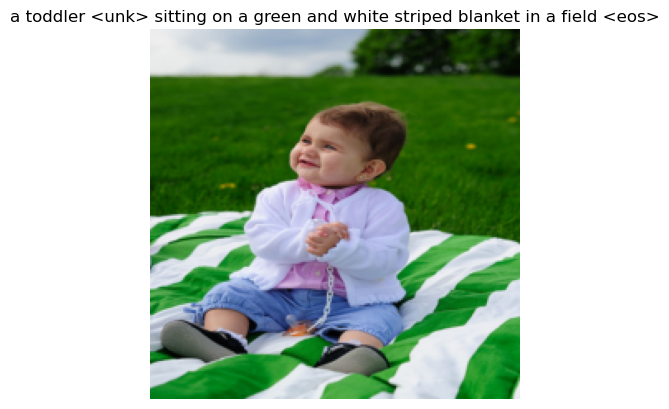

Epoch 14/15 - Training Loss: 1.6184, Validation Loss: 2.7105, BLEU Score: 0.0533, CIDEr Score: 0.0000, METEOR Score: 0.0000
Model saved at saved_model\model_epoch_14.pth
Epoch: 15, Batch: 200, Training Loss: 1.51168


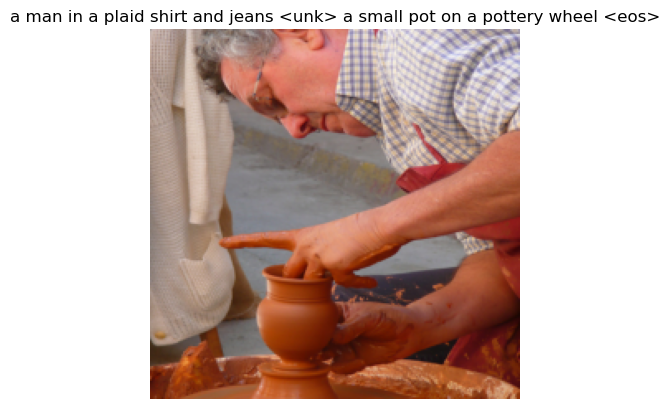

Epoch: 15, Batch: 400, Training Loss: 1.61526


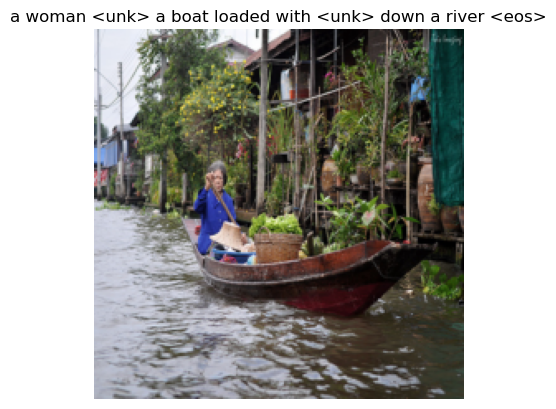

Epoch 15/15 - Training Loss: 1.5523, Validation Loss: 2.7421, BLEU Score: 0.0523, CIDEr Score: 0.0000, METEOR Score: 0.0000
Model saved at saved_model\model_epoch_15.pth


In [17]:
from src.utils import calculate_bleu_score, calculate_loss, calculate_cider_score, calculate_meteor_score

save_dir = "saved_model"

num_epochs = 15
print_every = 200

train_losses = []
val_losses = []
bleu_scores = []
cider_scores = []
meteor_scores = []

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0
    
    #Training loop
    for idx, (images, caption_token_ids, raw_captions) in enumerate(train_loader):
        images, caption_token_ids = images.to(device), caption_token_ids.to(device)

        optimizer.zero_grad()

        #Forward pass
        outputs, attentions = model(images, caption_token_ids)
        targets = caption_token_ids[:, 1:]  #Shift captions by 1 token for targets

        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        loss.backward()  #Backward pass
        optimizer.step()

        train_loss += loss.item()

        #Print training loss every `print_every` batches
        if (idx + 1) % print_every == 0:
            print(f'Epoch: {epoch}, Batch: {idx+1}, Training Loss: {loss.item():.5f}')

            model.eval()
            with torch.no_grad():
                img, _, _ = next(iter(train_loader))
                features = model.encoder(img[0:1].to(device))
                caps, attn_weights = model.decoder.generate_caption(features, vocab=flickr_dataset.vocabulary_builder.vocabulary)
                caption = ' '.join(caps)
                display_image(img[0], caption=caption, denormalize=True, mean=mean, std=std)
                
            model.train()
    
    #Average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    #Validation loss
    avg_val_loss = calculate_loss(model, test_loader, criterion, vocab_size, device)
    val_losses.append(avg_val_loss)
    
    #BLEU score
    avg_bleu_score = calculate_bleu_score(model, test_loader, vocab, device)
    bleu_scores.append(avg_bleu_score)
    
    #CIDEr and METEOR scores
    #avg_cider_score = calculate_cider_score(model, test_loader, vocab, device)
    avg_cider_score = 0

    #avg_meteor_score = calculate_meteor_score(model, test_loader, vocab, device)
    avg_meteor_score = 0

    cider_scores.append(avg_cider_score)
    meteor_scores.append(avg_meteor_score)

    print(f"Epoch {epoch}/{num_epochs} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, BLEU Score: {avg_bleu_score:.4f}, CIDEr Score: {avg_cider_score:.4f}, METEOR Score: {avg_meteor_score:.4f}")

    #Save model
    model_save_path = os.path.join(save_dir, f"model_epoch_{epoch}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'bleu_score': avg_bleu_score,
        'cider_score': avg_cider_score,
        'meteor_score': avg_meteor_score
    }, model_save_path)
    
    print(f"Model saved at {model_save_path}")


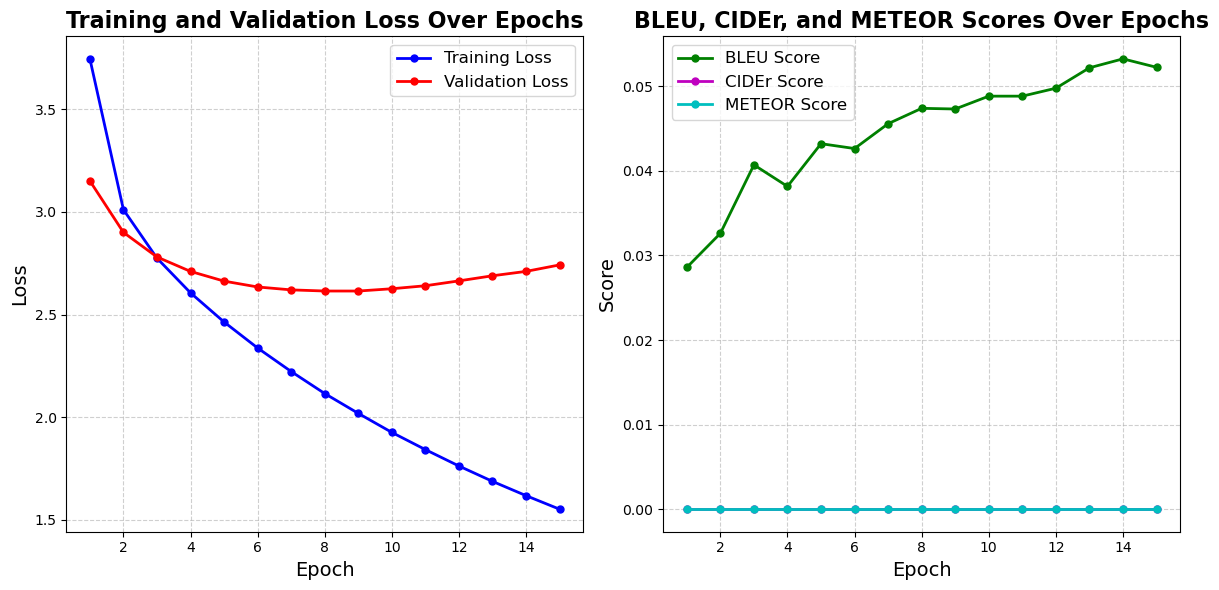

In [18]:
from src.utils import plot_metrics
plot_metrics(train_losses, val_losses, bleu_scores, cider_scores, meteor_scores, save_dir)